<a href="https://colab.research.google.com/github/Samin-Sadaf7/NN_works/blob/main/MicroGrad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**`Original idea and works:  Andrej Karpathy`**

In [6]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def func(x):
  return 2*x**2+4*x-7

In [8]:
func(3.0)

23.0

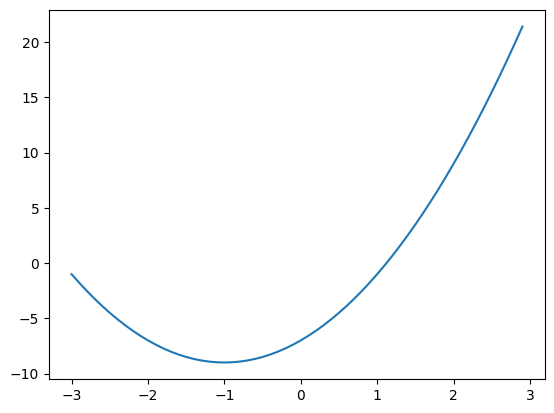

In [26]:
xs = np.arange(-3, 3,0.1)
ys = func(xs)
plt.plot(xs, ys)

###Derivative

Let  a∈R
  and let  f(x)
  be defined on an open interval 6 that contains  a.

The derivative of  f(x)
  at  x=a
  is denoted  f′(a)
  and is defined by
f′(a)=limh→0f(a+h)−f(a)h

if the limit exists.
When the above limit exists, the function  f(x)
  is said to be differentiable at  x=a.
  When the limit does not exist, the function  f(x)
  is said to be not differentiable at  x=a.

We can equivalently define the derivative  f′(a)
  by the limit
f′(a)=limx→af(x)−f(a)x−a.

To see that these two definitions are the same, we set  x=a+h
  and then the limit as  h
  goes to  0
  is equivalent to the limit as  x
  goes to  a.

In [29]:
h = 0.0000001
x = -2.5
(func(x+h)-func(x))/h

-5.99999978589949

In [30]:
a = 2.0
b = -3.0
c = 4.0
d = a*b +c
print(d)

-2.0


In [33]:
h = 0.001
#inputs
a = 2.0
b = -3.0
c = 4.0

d1 = a*b +c
a+=h
d2 = a*b +c
print('d1:', d1)
print('d2:', d2)
print("slope d with respect to a :" , (d2-d1)/h)

d1: -2.0
d2: -2.003
slope d with respect to a : -3.0000000000001137


In [34]:
h = 0.001
#inputs
a = 2.0
b = -3.0
c = 4.0

d1 = a*b +c
b+=h
d2 = a*b +c
print('d1:', d1)
print('d2:', d2)
print("slope d with respect to b :" , (d2-d1)/h)

d1: -2.0
d2: -1.9980000000000002
slope d with respect to b : 1.9999999999997797


In [35]:
h = 0.001
#inputs
a = 2.0
b = -3.0
c = 4.0

d1 = a*b +c
c+=h
d2 = a*b +c
print('d1:', d1)
print('d2:', d2)
print("slope d with respect to c :" , (d2-d1)/h)

d1: -2.0
d2: -1.9989999999999997
slope d with respect to c : 1.000000000000334


### Need a Data Structure to wrap up the data  in Neural Network
Building the core of MicroGrad

In [135]:
class Value:
  # constructor in python
  def __init__(self, data, _children=(), _op=(), label=''):
    self.data = data
    self._prev = set(_children)
    self.grad = 0.0
    self._op = _op
    self.label = label
  def __repr__(self):
    return f"Value(data:{self.data})"
  #operator overloading in python
  def __add__(self, other):
    out = Value(self.data + other.data, (self, other),'+')
    return out
  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other),'*')
    return out

a= Value(2.0, label='a')
b= Value(-3.0, label = 'b')
c= Value(-4,label ='c')
e= a*b
e.label='e'
d = e + c
d.label='d'
f = Value( -2.0, label = 'f')
L = d*f
L.label='L'
L

Value(data:20.0)

In [124]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label , n.data, n.grad ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

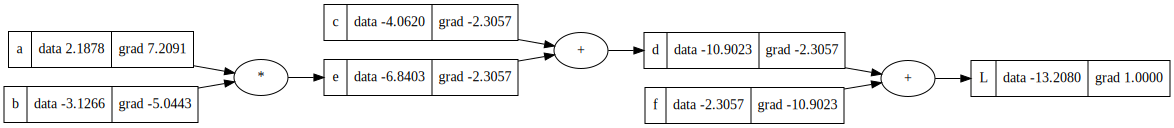

In [147]:
draw_dot(L)

In [146]:
# Manual Backpropagation
L.grad = 1.0
d.grad = f.data
f.grad = d.data
c.grad = d.grad * 1.0
e.grad = d.grad * 1.0
b.grad = e.grad * a.data
a.grad = e.grad * b.data

In [144]:
# Sinlge optimization run
a.data += (0.01 * a.grad)
b.data += (0.01 * b.grad)
c.data += (0.01 * c.grad)
f.data += (0.01 *  f.grad)

e = a * b
e.label = 'e'
d = e + c
d.label = 'd'
L = d + f
L.label ='L'
print(L.data)

-13.208033926399999


In [112]:
def man_def():
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(-4.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(-4.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  f.data+=h
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

man_def()

-9.99999999999801


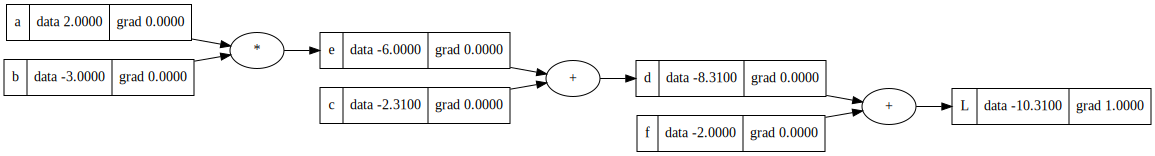